In [19]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.linear_model import LinearRegression

loo = LeaveOneOut()

# Define a fixed random seed for reproducibility
random = 42

# Load the data
data = pd.read_csv('./data250824.csv', index_col=[0], header=[0])

# Define feature sets
feature_sets = {
    'vi-qc': ['X3', 'X2', 'X1', 'X17'],
    'ga-qc': ['X2', 'X4', 'X15', 'X16'],
    'vi-ms': ['M43', 'M58', 'M2', 'M42'],
    'ga-ms': ['M2', 'M52', 'M67', 'M102']
}

# Define models with tuned hyperparameters (FOR WHOLE DATA SET)
tuned_hyperparameters = {
    'vi-qc': {
        'RF': {'bootstrap': False, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 10, 'min_samples_split': 11, 'n_estimators': 99, 'random_state': 42, 'n_jobs': -1},
        'SVR': {'C': 124.34299606015858, 'epsilon': 0.1436663234855287, 'kernel': 'rbf'},
        'XGB': {'booster':'gbtree', 'device':'cpu', 'objective':'reg:squarederror', 'verbosity': 2, 'tree_method':'auto', 'seed': 42, 'n_jobs': -1,
                'colsample_bytree': 0.10108222695147716, 'gamma': 0.03195015716291206, 'learning_rate': 0.1532942849179548, 'max_depth': 3, 'min_child_weight': 2.5672988836952646, 'reg_alpha': 0.28393875667236645, 'reg_lambda': 8.471227306156468, 'subsample': 0.36934305158488395}
    },
    'ga-qc': {
        'RF': {'bootstrap': True, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 59, 'random_state': 42, 'n_jobs': -1},
        'SVR': {'C': 1.0, 'epsilon': 0.1, 'kernel': 'rbf'},
        'XGB': {'booster':'gbtree', 'objective':'reg:squarederror', 'verbosity': 2, 'tree_method':'auto', 'seed': 42, 'n_jobs': -1,
                'colsample_bytree': 0.1360716562727799, 'gamma': 0.16137390404554144, 'learning_rate': 0.2727409061252117, 'max_depth': 2, 'min_child_weight': 3.9511645755552687, 'reg_alpha': 0.16804646499331374, 'reg_lambda': 8.104479048297152, 'subsample': 0.6070548406804517},
        'MLR': {}
    },
    'vi-ms': {
        'RF': {'bootstrap': True, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 147, 'random_state': 42, 'n_jobs': -1},
        'SVR': {'C': 1.6028197376373123, 'degree': 4, 'epsilon': 0.0, 'kernel': 'rbf'},
        'XGB': {'booster':'gbtree', 'device':'cpu', 'objective':'reg:squarederror', 'verbosity': 2, 'tree_method':'auto', 'seed': 42, 'validate_parameters': True, 'n_jobs': -1,
                'colsample_bytree': 0.9915139189418589, 'gamma': 0.7183487649345512, 'learning_rate': 0.04234226319867907, 'max_depth': 6, 'min_child_weight': 0.7111973058597089, 'reg_alpha': 0.002473915667967762, 'reg_lambda': 0.2952577589021902, 'subsample': 0.33404173513149854}
    },
    'ga-ms': {
        'RF': {'bootstrap': True, 'max_depth': None, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 126, 'random_state': 42, 'n_jobs': -1},
        'SVR': {'C': 4.752986507554117, 'epsilon': 0.21223832828344527, 'kernel': 'rbf'},
        'XGB': {'booster':'gbtree', 'device':'cpu', 'objective':'reg:squarederror', 'verbosity': 2, 'tree_method':'auto', 'seed': 42, 'validate_parameters': True, 'n_jobs': -1,
                },
        'MLR': {}
    }
}

scaler = StandardScaler()
# Target variable
y = data['pIC50']

# Initialize results storage
results = []

# Calculate R-squared for each model-feature set combination using the entire training set (FOR WHOLE DATA SET)
for feature_set_name, features in feature_sets.items():
    X = data[features]
    X_train = X.iloc[:22]
    X_test = X.iloc[22:28]
    y_train = y.iloc[:22]
    y_test = y.iloc[22:28]
    X_val = X.iloc[28:31]
    y_val = y.iloc[28:31]
    #X_new = X.iloc[31:]
    #y_new = y.iloc[31:]

    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_val_scaled = scaler.transform(X_val)
    for model_name, hyperparams in tuned_hyperparameters[feature_set_name].items():
        if model_name == 'RF':
            model = RandomForestRegressor(**hyperparams)
            X_train_model = X_train
            X_test_model = X_test
            X_val_model = X_val
        elif model_name == 'SVR':
            model = SVR(**hyperparams)
            X_train_model = X_train_scaled
            X_test_model = X_test_scaled
            X_val_model = X_val_scaled
        elif model_name == 'XGB':
            model = XGBRegressor(**hyperparams)
            X_train_model = X_train
            X_test_model = X_test
            X_val_model = X_val
        elif model_name == 'MLR':
            # Custom Linear Regression model using custom coefficients
            model = LinearRegression(**hyperparams)
            X_train_model = X_train
            X_test_model = X_test
            X_val_model = X_val

        model.fit(X_train_model, y_train)
        y_train_pred = model.predict(X_train_model)
        y_test_pred = model.predict(X_test_model)
        r_squared = model.score(X_train_model, y_train)

        rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
        rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

        results.append({
            'Feature Set': feature_set_name,
            'Model': model_name,
            'R2': r_squared,
            'RMSE Train': rmse_train,
            'RMSE Test': rmse_test,
        })

# Convert results to DataFrame
df1 = pd.DataFrame(results)

# Display the DataFrame
print(df1)

   Feature Set Model        R2  RMSE Train  RMSE Test
0        vi-qc    RF  0.847888    0.594189   0.734617
1        vi-qc   SVR  0.896175    0.490899   0.316750
2        vi-qc   XGB  0.904510    0.470784   0.929190
3        ga-qc    RF  0.946405    0.352699   0.245898
4        ga-qc   SVR  0.904420    0.471004   0.285004
5        ga-qc   XGB  0.929542    0.404395   0.426346
6        ga-qc   MLR  0.917144    0.438535   0.458703
7        vi-ms    RF  0.980792    0.211145   0.453129
8        vi-ms   SVR  0.942883    0.364102   0.573568
9        vi-ms   XGB  0.920793    0.428770   0.848765
10       ga-ms    RF  0.955732    0.320544   0.325071
11       ga-ms   SVR  0.954571    0.324721   0.274233
12       ga-ms   XGB  1.000000    0.000800   0.215931
13       ga-ms   MLR  0.927344    0.410656   0.263927


In [20]:
from math import sqrt

# Initialize results storage
results = []

# Perform LOOCV for training set
loo = LeaveOneOut()

for feature_set_name, features in feature_sets.items():
    X = data[features]
    X_train = X.iloc[:22]
    y_train = y.iloc[:22]

    # Scale the features for SVR; MLR does not need scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Compute Total Sum of Squares (TSS) as a scalar
    y_train_mean = np.mean(y_train)
    tss = np.sum((y_train - y_train_mean) ** 2)  # TSS is a scalar value

    for model_name, hyperparams in tuned_hyperparameters.get(feature_set_name, {}).items():
        if model_name == 'RF':
            model = RandomForestRegressor(**hyperparams)
        elif model_name == 'SVR':
            # Scale features for SVR
            model = SVR(**hyperparams)
        elif model_name == 'XGB':
            model = XGBRegressor(**hyperparams)
        elif model_name == 'MLR':
            # Do not use scaled features for MLR
            model = LinearRegression()

        y_true = []
        y_pred = []
        e_square = []
        root_square = []
        # Loop through LOO splits
        for train_index, test_index in loo.split(X_train):
            X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
            y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]

            # Scale training and test data only for SVR
            if model_name == 'SVR':
                # Fit the scaler on the training data for this split
                scaler = StandardScaler()
                X_train_cv = scaler.fit_transform(X_train_cv)
                X_test_cv = scaler.transform(X_test_cv)  # Use the fitted scaler to transform the test set

            model.fit(X_train_cv, y_train_cv)
            prediction = model.predict(X_test_cv)[0]

            e_pangkat2 = (y_test_cv.values[0] - prediction) ** 2
            y_true.append(y_test_cv.values[0])
            y_pred.append(prediction)
            e_square.append(e_pangkat2)
            root_square.append(sqrt(e_pangkat2))

        # Calculate PRESS (sum of squared prediction errors) and R-squared for LOOCV
        press = sum(e_square)
        r_squared_cv = 1 - (press / tss)

        mse = np.mean(e_square)
        rmse = np.sqrt(mse)

        rmse_2 = np.mean(root_square)
        # Store results
        results.append({
            'Feature Set': feature_set_name,
            'Model': model_name,
            'Q2': r_squared_cv,
        })

# Convert results to DataFrame
df2 = pd.DataFrame(results)

# Display the DataFrame
print(df2)

   Feature Set Model        Q2
0        vi-qc    RF  0.754594
1        vi-qc   SVR  0.771609
2        vi-qc   XGB  0.790540
3        ga-qc    RF  0.843849
4        ga-qc   SVR  0.763578
5        ga-qc   XGB  0.796072
6        ga-qc   MLR  0.868526
7        vi-ms    RF  0.870657
8        vi-ms   SVR  0.817786
9        vi-ms   XGB  0.796428
10       ga-ms    RF  0.736149
11       ga-ms   SVR  0.821945
12       ga-ms   XGB  0.683073
13       ga-ms   MLR  0.880134


In [21]:
# Convert results to DataFrame
df_original = pd.merge(df1, df2, on=['Feature Set', 'Model'], how='inner')

# Display the DataFrame
print(df_original)

   Feature Set Model        R2  RMSE Train  RMSE Test        Q2
0        vi-qc    RF  0.847888    0.594189   0.734617  0.754594
1        vi-qc   SVR  0.896175    0.490899   0.316750  0.771609
2        vi-qc   XGB  0.904510    0.470784   0.929190  0.790540
3        ga-qc    RF  0.946405    0.352699   0.245898  0.843849
4        ga-qc   SVR  0.904420    0.471004   0.285004  0.763578
5        ga-qc   XGB  0.929542    0.404395   0.426346  0.796072
6        ga-qc   MLR  0.917144    0.438535   0.458703  0.868526
7        vi-ms    RF  0.980792    0.211145   0.453129  0.870657
8        vi-ms   SVR  0.942883    0.364102   0.573568  0.817786
9        vi-ms   XGB  0.920793    0.428770   0.848765  0.796428
10       ga-ms    RF  0.955732    0.320544   0.325071  0.736149
11       ga-ms   SVR  0.954571    0.324721   0.274233  0.821945
12       ga-ms   XGB  1.000000    0.000800   0.215931  0.683073
13       ga-ms   MLR  0.927344    0.410656   0.263927  0.880134


In [27]:
import random
from sklearn.utils import shuffle

n_randomizations = 100
y_random_results = []

for feature_set_name, features in feature_sets.items():
    X = data[features]
    X_train = X.iloc[:22]
    y_train = y.iloc[:22]
    
    # Prepare scaled features
    X_train_scaled = scaler.fit_transform(X_train)
    
    for model_name, hyperparams in tuned_hyperparameters[feature_set_name].items():
        for run in range(n_randomizations):
            y_train_shuffled = shuffle(y_train, random_state=run)
            
            if model_name == 'RF':
                model = RandomForestRegressor(**hyperparams)
                X_model = X_train
            elif model_name == 'SVR':
                model = SVR(**hyperparams)
                X_model = X_train_scaled
            elif model_name == 'XGB':
                model = XGBRegressor(**hyperparams)
                X_model = X_train
            elif model_name == 'MLR':
                model = LinearRegression()
                X_model = X_train
            
            model.fit(X_model, y_train_shuffled)
            y_pred = model.predict(X_model)
            
            r2_rand = r2_score(y_train_shuffled, y_pred)
            rmse_rand = np.sqrt(mean_squared_error(y_train_shuffled, y_pred))
            
            y_random_results.append({
                'Feature Set': feature_set_name,
                'Model': model_name,
                'Run': run + 1,
                'R2 Y-Random': r2_rand,
                'RMSE Y-Random': rmse_rand,
                'Y_Shuffled': y_train_shuffled.values.tolist()  # Save the shuffled y
            })

# Convert Y-randomization results to DataFrame
df_y_random = pd.DataFrame(y_random_results)

# Save or inspect results
df_y_random.to_csv('./y_random_results.csv', index=False)
print(df_y_random.groupby(['Feature Set', 'Model'])[['R2 Y-Random', 'RMSE Y-Random']].agg(['mean', 'std']))


                  R2 Y-Random               RMSE Y-Random          
                         mean           std          mean       std
Feature Set Model                                                  
ga-ms       MLR      0.202431  1.111980e-01      1.357206  0.096348
            RF       0.793315  3.845803e-02      0.689498  0.066047
            SVR      0.562385  1.245093e-01      0.996389  0.152199
            XGB      1.000000  7.654610e-08      0.000864  0.000096
ga-qc       MLR      0.190482  1.092708e-01      1.367491  0.094816
            RF       0.656906  6.038501e-02      0.888690  0.081448
            SVR      0.252303  1.206235e-01      1.312875  0.109185
            XGB      0.620658  7.608868e-02      0.933536  0.095257
vi-ms       RF       0.815697  3.785454e-02      0.650503  0.068332
            SVR      0.327838  1.388970e-01      1.242217  0.131107
            XGB      0.734736  3.901541e-02      0.782493  0.058568
vi-qc       RF       0.117970  8.596964e-02     

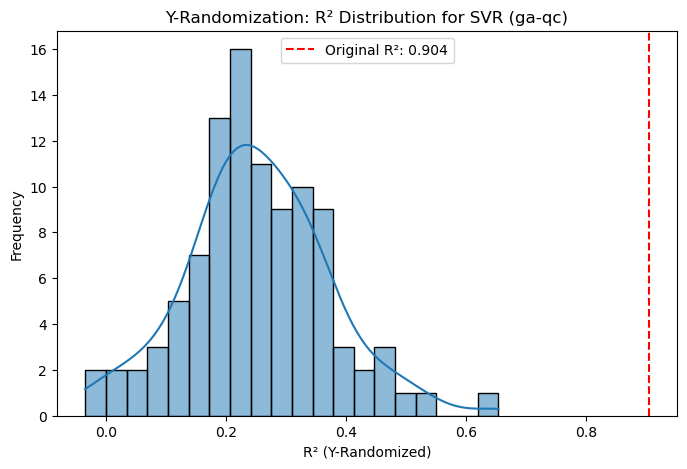

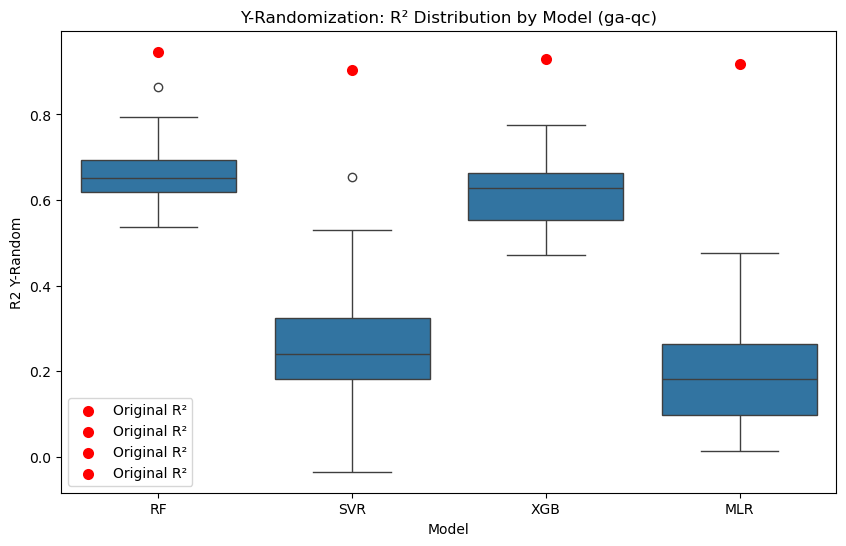

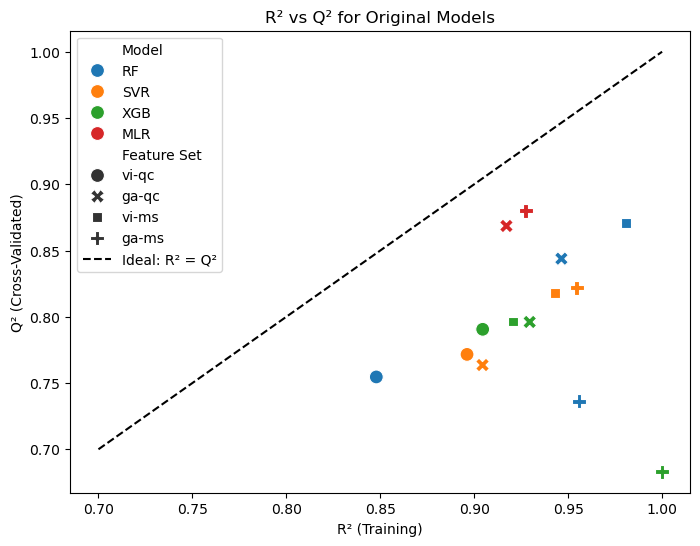

Empirical p-value for SVR (ga-qc): 0.0000


0.0

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Inputs ---
# df_y_random: DataFrame with Y-randomization results, must include columns ['Feature Set', 'Model', 'Run', 'R2 Y-Random', 'RMSE Y-Random']
# df_original: DataFrame with original model results, must include ['Feature Set', 'Model', 'R2', 'Q2']

# Example:
# df_y_random = pd.read_csv('y_random_results.csv')
# df_original = pd.read_csv('original_model_results.csv')

# -- 1. Histogram of R2 (Y-Randomization) for a specific model and feature set
def plot_r2_histogram(feature_set, model):
    subset = df_y_random[(df_y_random['Feature Set'] == feature_set) & (df_y_random['Model'] == model)]
    original_r2 = df_original[(df_original['Feature Set'] == feature_set) & (df_original['Model'] == model)]['R2'].values[0]

    plt.figure(figsize=(8,5))
    sns.histplot(subset['R2 Y-Random'], kde=True, bins=20)
    plt.axvline(original_r2, color='red', linestyle='--', label=f'Original R²: {original_r2:.3f}')
    plt.title(f'Y-Randomization: R² Distribution for {model} ({feature_set})')
    plt.xlabel('R² (Y-Randomized)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# -- 2. Boxplot of R2 from Y-randomization for all models and overlay original R2
def plot_r2_boxplot(feature_set):
    subset_random = df_y_random[df_y_random['Feature Set'] == feature_set]
    subset_original = df_original[df_original['Feature Set'] == feature_set]

    plt.figure(figsize=(10,6))
    sns.boxplot(data=subset_random, x='Model', y='R2 Y-Random')
    sns.stripplot(data=subset_original, x='Model', y='R2', color='red', size=8, label='Original R²', jitter=True)
    plt.title(f'Y-Randomization: R² Distribution by Model ({feature_set})')
    plt.legend()
    plt.show()

# -- 3. Scatter plot Q2 vs R2 for original models
def plot_q2_vs_r2():
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_original, x='R2', y='Q2', hue='Model', style='Feature Set', s=100)
    plt.plot([0.7,1], [0.7,1], 'k--', label='Ideal: R² = Q²')
    plt.xlabel('R² (Training)')
    plt.ylabel('Q² (Cross-Validated)')
    plt.title('R² vs Q² for Original Models')
    plt.legend()
    plt.show()

# -- 4. Calculate empirical p-value of original R2 vs randomized R2
def calc_empirical_p(feature_set, model):
    r2_random = df_y_random[(df_y_random['Feature Set'] == feature_set) & (df_y_random['Model'] == model)]['R2 Y-Random']
    original_r2 = df_original[(df_original['Feature Set'] == feature_set) & (df_original['Model'] == model)]['R2'].values[0]

    p_val = np.mean(r2_random >= original_r2)
    print(f"Empirical p-value for {model} ({feature_set}): {p_val:.4f}")
    return p_val

# --- Example Usage ---

# Plot histogram for one model and feature set
plot_r2_histogram(feature_set='ga-qc', model='SVR')

# Plot boxplot for one feature set
plot_r2_boxplot(feature_set='ga-qc')

# Plot Q2 vs R2 for all original models
plot_q2_vs_r2()

# Calculate empirical p-value for a model and feature set
calc_empirical_p(feature_set='ga-qc', model='SVR')


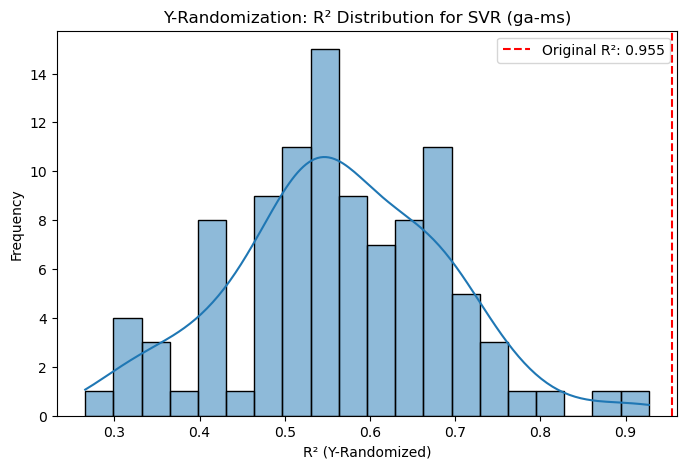

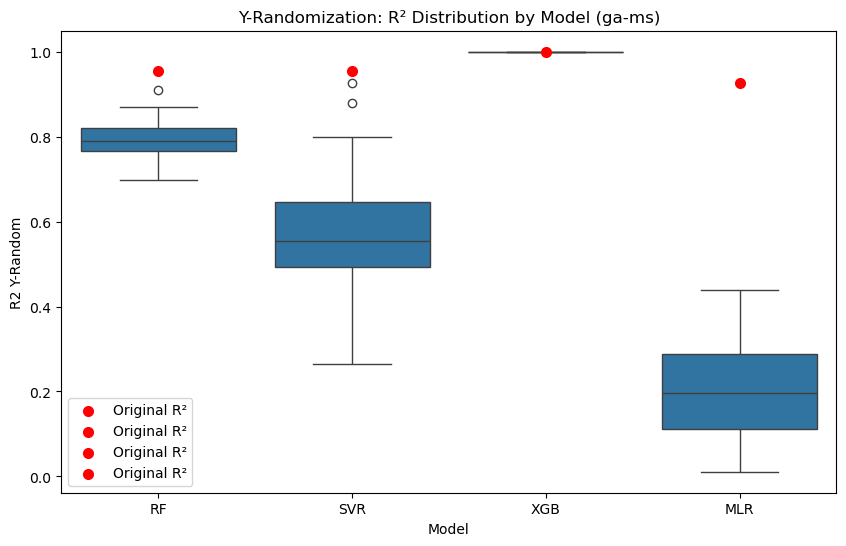

Empirical p-value for SVR (ga-ms): 0.0000


0.0

In [30]:
# Plot histogram for one model and feature set
plot_r2_histogram(feature_set='ga-ms', model='SVR')

# Plot boxplot for one feature set
plot_r2_boxplot(feature_set='ga-ms')

# Calculate empirical p-value for a model and feature set
calc_empirical_p(feature_set='ga-ms', model='SVR')


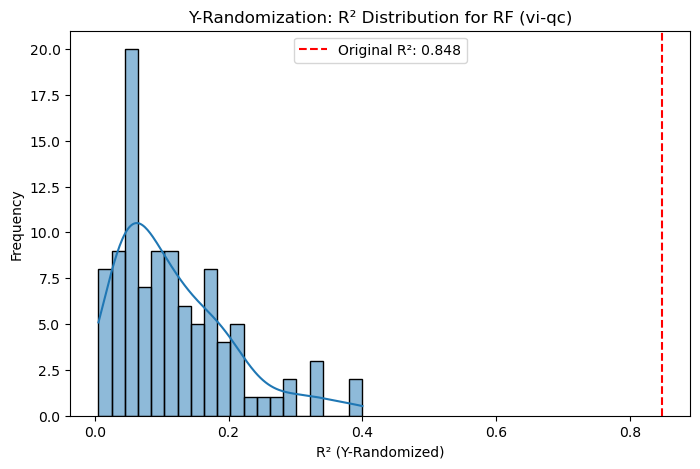

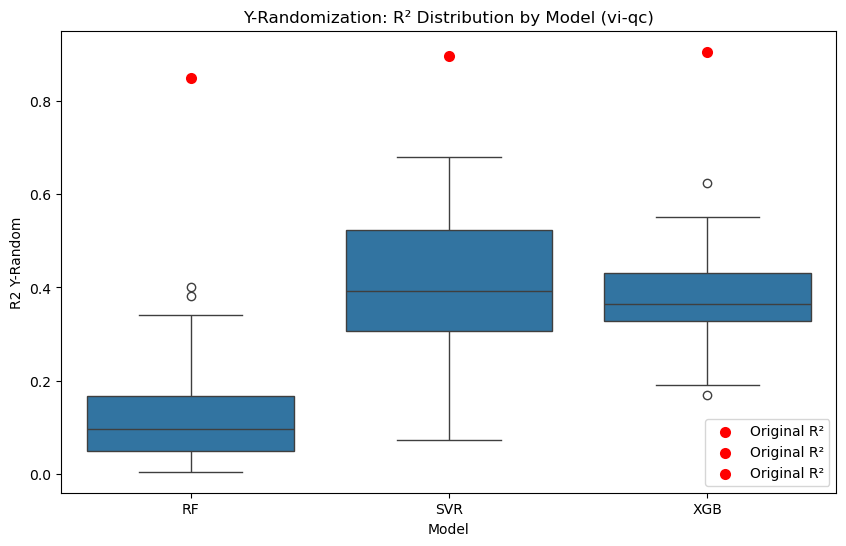

Empirical p-value for RF (vi-qc): 0.0000


0.0

In [32]:
# Plot histogram for one model and feature set
plot_r2_histogram(feature_set='vi-qc', model='RF')

# Plot boxplot for one feature set
plot_r2_boxplot(feature_set='vi-qc')

# Calculate empirical p-value for a model and feature set
calc_empirical_p(feature_set='vi-qc', model='RF')

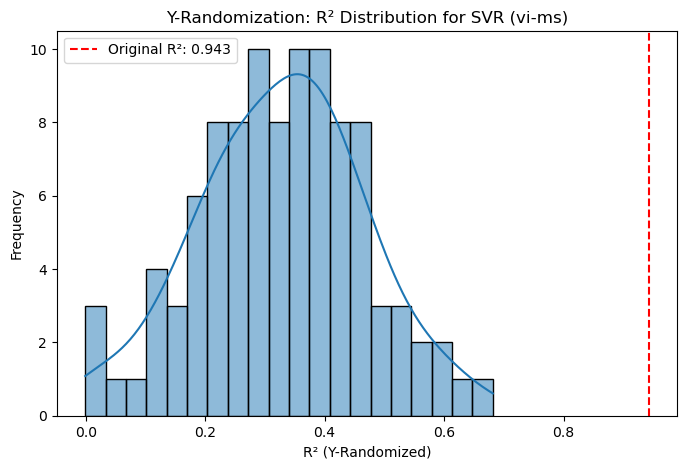

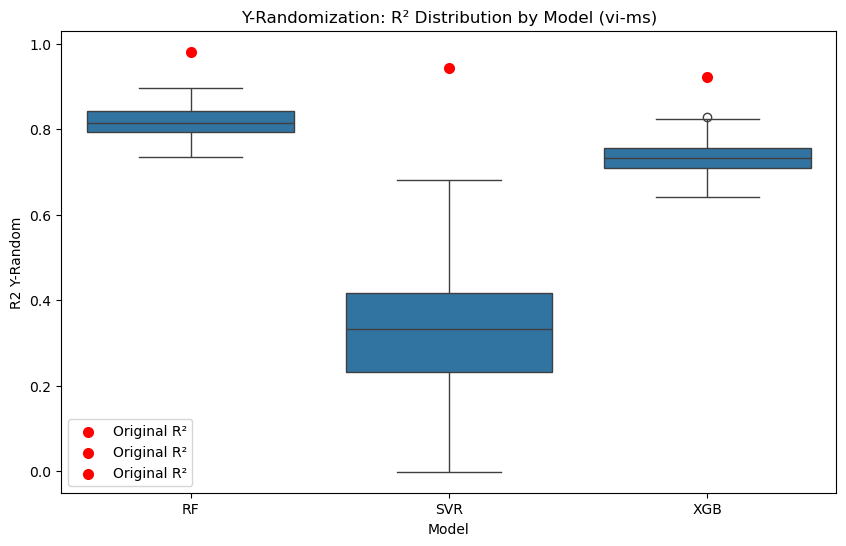

Empirical p-value for SVR (vi-ms): 0.0000


0.0

In [35]:
# Plot histogram for one model and feature set
plot_r2_histogram(feature_set='vi-ms', model='SVR')

# Plot boxplot for one feature set
plot_r2_boxplot(feature_set='vi-ms')

# Calculate empirical p-value for a model and feature set
calc_empirical_p(feature_set='vi-ms', model='SVR')